In [4]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

import numpy as np
import scipy as sp
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colormaps

from analysis.analysis import *
from analysis.plot import *
from analysis.emg import *
from analysis.model import *
from analysis.collection import *

%matplotlib inline

## look at GMM covariance task/null space projections

In [2]:
subjects = load_subjects()

In [3]:
subject_idx = 7

In [7]:
# test subspace projection
decoder = get_decoder(subjects[subject_idx])
task, null = compute_subspaces(decoder)
print(task.shape, null.shape)

(2, 64) (62, 64)


In [11]:
def stacked_subspace_projection(C,d):
    t, n = compute_subspaces(d)
    s = np.row_stack([t,n])
    return subspace_projection(C, s)

In [9]:
models = load_trial_models(subject_idx)

In [13]:
# project each component of each model
# model, component, projection vec
projections = np.zeros(shape=(5,12,64))
markers = [".","*","o","v","s"]
for i, model in enumerate(models):
    for k, cov in enumerate(model.covariances_):
        projections[i,k,:] = stacked_subspace_projection(cov,decoder)

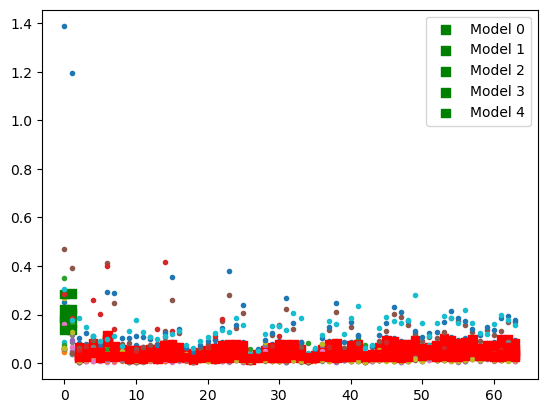

In [15]:
# plot the projections and color the mean for each model
for model_idx in range(5):
    for cpt_idx in range(4):
        p = projections[model_idx, cpt_idx]
        plt.scatter(np.arange(p.shape[0]), p, marker=".")
    plt.scatter(np.arange(p.shape[0]), np.mean(projections, axis=1)[model_idx], marker=markers[i], c=["g","g"] + ["r" for _ in range(62)], label=f"Model {model_idx}")
plt.legend()

In [46]:
mean_projections = np.zeros(shape=(46,5,12,3))
markers = [".","*","o","v","s"]
for subject_idx in range(46):
    decoder = get_decoder(subjects[subject_idx])
    models = load_log_trial_models(subject_idx)
    task, null = compute_subspaces(decoder)
    for i, model in enumerate(models):
        for k, cov in enumerate(model.covariances_):
            mean_projections[subject_idx,i,k,0] = mean_quadratic_form(cov,task)[0] # *models[i].weights_[k]
            mean_projections[subject_idx,i,k,1] = mean_quadratic_form(cov,null)[0] # *models[i].weights_[k]            
            mean_projections[subject_idx,i,k,2] = mean_projections[subject_idx,i,k,0] / mean_projections[subject_idx,i,k,1]

Model 0 <-> Model 1 p value: 20.06804309134689%
Model 1 <-> Model 2 p value: 25.735665245001876%
Model 2 <-> Model 3 p value: 81.04526785842934%
Model 3 <-> Model 4 p value: 69.21590979640746%


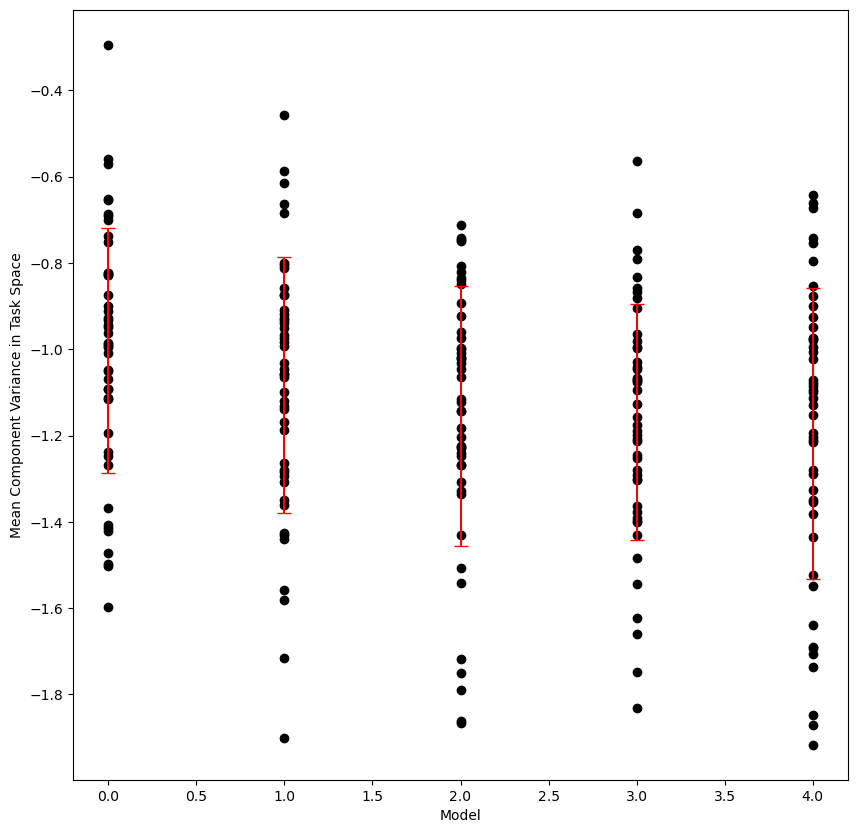

In [57]:
plt.figure(figsize=(10,10))
for s in range(46):
    for i in range(5):
        # for k in range(12):
        plt.plot(i, np.log(np.mean(mean_projections[s,i,:,0])),'ko')
# subjects x models
subject_means = np.log(np.mean(mean_projections[:,:,:,0],axis=(2)))

plt.errorbar(x=list(range(5)),y=np.mean(subject_means,axis=0),yerr=np.std(subject_means,axis=0),color='r',capsize=5,linestyle="none")
plt.xlabel("Model")
plt.ylabel("Mean Component Variance in Task Space")

for i in range(4):
    stats = sp.stats.ttest_ind(subject_means[:,i],subject_means[:,i+1],equal_var=False)
    print(f"Model {i} <-> Model {i+1} p value: {stats.pvalue*100}%")

Model 0 <-> Model 1 p value: 0.06656987512011672%
Model 1 <-> Model 2 p value: 23.716374965325006%
Model 2 <-> Model 3 p value: 36.18382004267547%
Model 3 <-> Model 4 p value: 90.15196898053807%


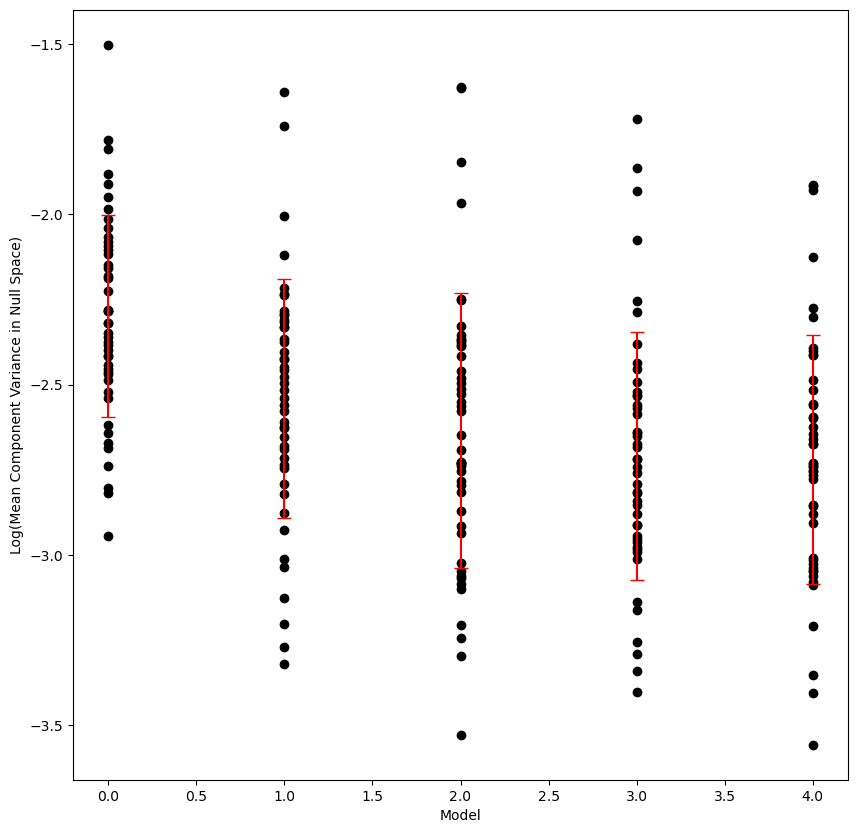

In [56]:
plt.figure(figsize=(10,10))
for s in range(46):
    for i in range(5):
        # for k in range(12):
        plt.plot(i, np.log(np.mean(mean_projections[s,i,:,1])),'ko')
# subjects x models
subject_means = np.log(np.mean(mean_projections[:,:,:,1],axis=(2)))

plt.errorbar(x=list(range(5)),y=np.mean(subject_means,axis=0),yerr=np.std(subject_means,axis=0),color='r',capsize=5,linestyle="none")
plt.xlabel("Model")
plt.ylabel("Log(Mean Component Variance in Null Space)")

for i in range(4):
    stats = sp.stats.ttest_ind(subject_means[:,i],subject_means[:,i+1],equal_var=False)
    print(f"Model {i} <-> Model {i+1} p value: {stats.pvalue*100}%")

Model 0 <-> Model 1 p value: 1.7491711990906675%
Model 1 <-> Model 2 p value: 54.13203794278052%
Model 2 <-> Model 3 p value: 26.166335930760624%
Model 3 <-> Model 4 p value: 66.10853519138682%


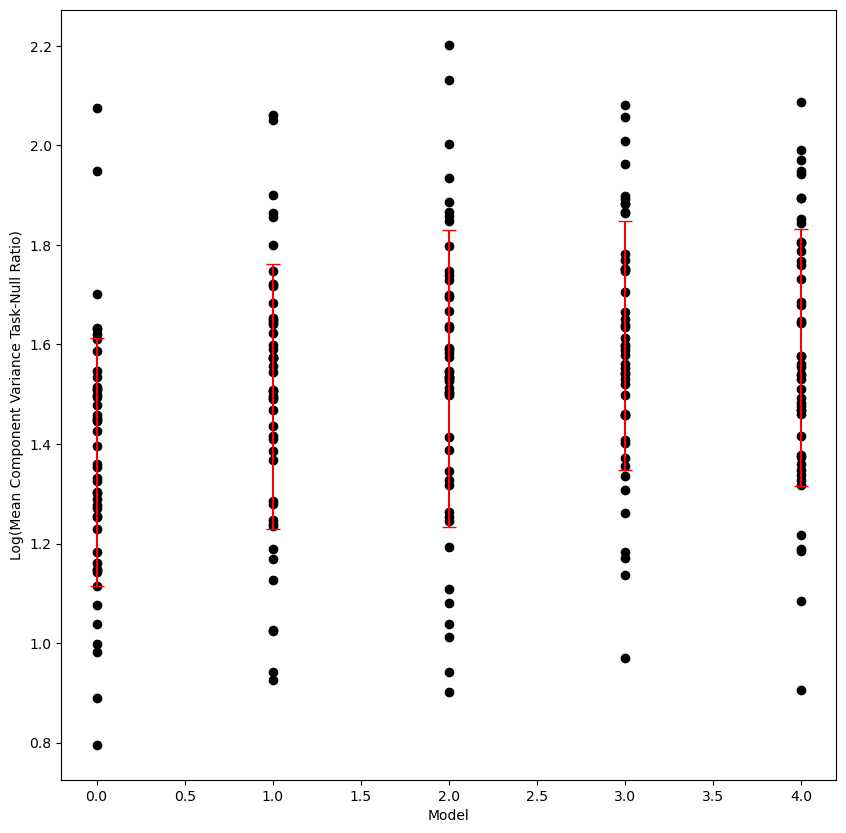

In [55]:
plt.figure(figsize=(10,10))
for s in range(46):
    for i in range(5):
        # for k in range(12):
        plt.plot(i, np.log(np.mean(mean_projections[s,i,:,2])),'ko')

# subjects x models
subject_means = np.log(np.mean(mean_projections[:,:,:,2],axis=(2)))

plt.errorbar(x=list(range(5)),y=np.mean(subject_means,axis=0),yerr=np.std(subject_means,axis=0),color='r',capsize=5,linestyle="none")
plt.xlabel("Model")
plt.ylabel("Log(Mean Component Variance Task-Null Ratio)")

for i in range(4):
    stats = sp.stats.ttest_ind(subject_means[:,i],subject_means[:,i+1],equal_var=False)
    print(f"Model {i} <-> Model {i+1} p value: {stats.pvalue*100}%")

#### To look at task/null variance, we need to focus on the ERROR signal-- this is the NOISE apart from doing the task itself. 

#### BUT we can't do this! Because we don't have a trajectory --> EMG model... we can:
- try to interpret this in light of the task data
- fit a model from trajectory to EMG, then subtract that off from the EMG? E.g. A*t = e', err = |e - e'|**2 ?

If we take the HIT emg ends, stack those, then fit a model from that point to that EMG activity, then we could subtract that EMG activity off of the other EMG.

Now we have error_emg for every trial. Then we can try to project.

What we have now is still interesting, it's looking at on-manifold activity vs. off. But this is kind of "manifold activity" (are we moving on or off manifold), less specific than "manifold error" (are we making mistakes / irrelevant activity on or off manifold).